In [4]:
import pandas as pd 
import numpy as np 
import statsmodels as st 
import sklearn 
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt

import seaborn as sns

In [5]:
train_df = pd.read_csv('../../data/feature/cb_train.csv')
val_df = pd.read_csv('../../data/feature/cb_validation.csv')
test_df = pd.read_csv('../../data/feature/cb_test.csv')

In [6]:
train_df.head()
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27499 entries, 0 to 27498
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Gender                      27499 non-null  int64
 1   Age                         27499 non-null  int64
 2   Ethnicity                   27499 non-null  int64
 3   Educational_Level           27499 non-null  int64
 4   Income                      27499 non-null  int64
 5   Country_region              27499 non-null  int64
 6   Hotel_Type                  27499 non-null  int64
 7   Meal_Type                   27499 non-null  int64
 8   Visted_Previously           27499 non-null  int64
 9   Previous_Cancellations      27499 non-null  int64
 10  Deposit_type                27499 non-null  int64
 11  Booking_channel             27499 non-null  int64
 12  Required_Car_Parking        27499 non-null  int64
 13  Use_Promotion               27499 non-null  int64
 14  Room_R

In [7]:
def cals_VIF(df):

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]

    return vif

    

In [8]:
def pca_perc_var_plot(df):
    df = df.copy()
    pca = PCA(n_components=df.shape[1])
    pca_data = pca.fit_transform(df)

    percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
    cumm_var_explained = np.cumsum(percent_var_explained)
    plt.plot(cumm_var_explained, 'bo-')
    plt.grid()
    plt.title("percentage of variation explained")
    plt.xlabel("n_components")
    plt.ylabel("% variance explained")
    plt.show()

def pca_scree_plot(df):
    df = df.copy()
    pca = PCA(n_components=df.shape[1])
    pca_data = pca.fit_transform(df)

    pcs = np.arange(pca.n_components_)+1
    plt.plot(pcs, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

In [9]:
def value_to_color(n_colors, palette, color_min, color_max,val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

def hinton_plot(data, columns=[], corr_func='pearson'):
    if columns == []:
        corr = data.corr(method=corr_func)
    else:
        data = data.loc[:,columns]
        corr = data.corr(method=corr_func)

    corr = pd.melt(corr.reset_index(), id_vars='index')
    corr.columns = ['x','y','value']

    x = corr['x']
    y = corr['y']
    size = corr['value']

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1)
    ax = plt.subplot(plot_grid[:,:-1])

    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}

    size_scale = 500
    n_colors = 256
    palette = sns.diverging_palette(20, 220, n=n_colors) 
    color_min, color_max = [-1, 1]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size*size_scale,
        c=size.apply(lambda x: value_to_color(n_colors, palette, color_min, color_max, x)),
        marker='s'
    )

    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.set_title("hintonmap for multi-colinearity between features")

    ax = plt.subplot(plot_grid[:,-1])

    col_x = [0]*len(palette)
    bar_y = np.linspace(color_min, color_max, n_colors)
    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )

    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right()

In [10]:
def corr_wt_target(df, target, columns):
    absCorr = []
    for col in columns:
        absCorr.append(abs(df[target].corr(df[col])))

    ax = sns.lineplot(columns,absCorr)
    ax.set_xticklabels(df.columns,rotation=45, horizontalalignment='right')
    ax.set_title("Absolute correlation of features with the target")

d:\competitions\datastorm-2021\venv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys
d:\competitions\datastorm-2021\venv\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


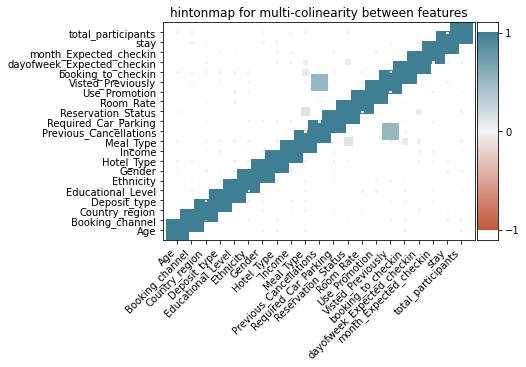

In [11]:
hinton_plot(train_df, train_df.columns.values)

d:\competitions\datastorm-2021\venv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


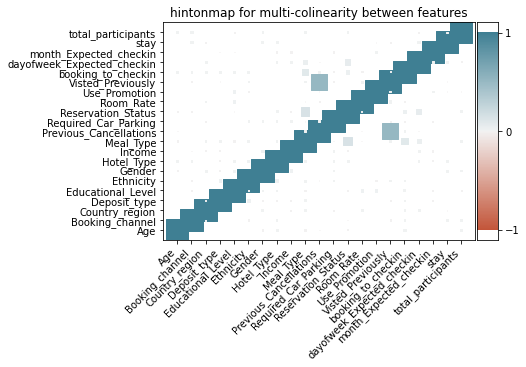

In [12]:
hinton_plot(train_df, train_df.columns.values, 'spearman')

In [13]:
train_df.iloc[:, :-1].columns

Index(['Gender', 'Age', 'Ethnicity', 'Educational_Level', 'Income',
       'Country_region', 'Hotel_Type', 'Meal_Type', 'Visted_Previously',
       'Previous_Cancellations', 'Deposit_type', 'Booking_channel',
       'Required_Car_Parking', 'Use_Promotion', 'Room_Rate',
       'month_Expected_checkin', 'dayofweek_Expected_checkin', 'stay',
       'booking_to_checkin', 'total_participants'],
      dtype='object')

In [ ]:
pca_scree_plot(train_df.iloc[:, :-1])

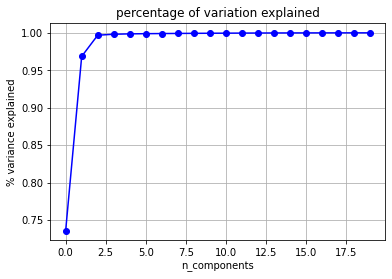

In [11]:
pca_perc_var_plot(train_df.iloc[:, :-1])

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
ipykernel_launcher:7: UserWarning: FixedFormatter should only be used together with FixedLocator


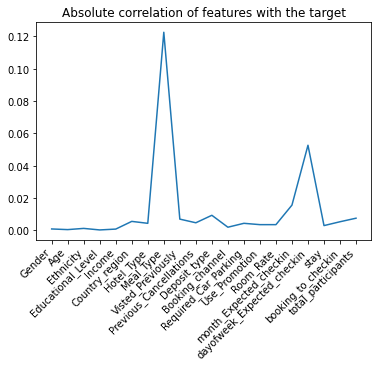

In [12]:
cols = train_df.columns[:-1]
corr_wt_target(train_df,'Reservation_Status', cols)

In [13]:
cals_VIF(train_df)

,variables,VIF
0,Gender,1.961509
1,Age,7.982258
2,Ethnicity,2.731756
3,Educational_Level,3.357354
4,Income,2.428431
5,Country_region,3.253738
6,Hotel_Type,2.442342
7,Meal_Type,1.813988
8,Visted_Previously,2.006487
9,Previous_Cancellations,1.517672


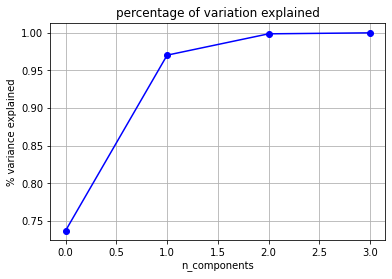

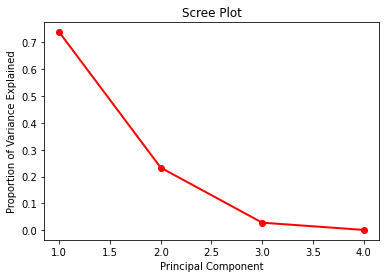

In [14]:
tol_pca = PCA(n_components=4)
y = train_df.iloc[:, -1]
tol_pca_df = tol_pca.fit_transform(train_df.iloc[:, :-1])
pca_perc_var_plot(tol_pca_df)
pca_scree_plot(tol_pca_df)

In [15]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [25]:
model = CatBoostClassifier(loss_function='F1', task_type='GPU', random_seed=443)

In [26]:
model.fit(tol_pca_df,y,plot=False)

CatBoostError: Invalid loss_function='F1': for classifier use Logloss, CrossEntropy, MultiClass, MultiClassOneVsAll or custom objective object

In [19]:
pca_val_X = tol_pca.transform(val_df.iloc[:, :-1])
val_y = val_df.iloc[:,-1]
y_val_pred = model.predict(pca_val_X)


In [20]:
f1_score(val_y, y_val_pred, average='macro')

0.24563017479300828